# PS S03E02: A Complete EDA ⭐️

This EDA gives useful insights when designig a machine learning pipeline for this episode competition

**Versions**
- v1: Inital EDA
- v2: Changing countplots to percentage plots
- v19: added correlations plots and additional insights about `smoke==unknown`
- v21: added feature importances for a linear model with OneHotEncoding


# Table of Content


1. [The Labels](#The-Labels)
1. [The Data](#The-Data)
1. [Features Distributions](#Features-Distributions)
    1. [Numerical Features Distribution](#Numerical-Features-Distribution)
    1. [Categorical Features Distribution](#Categorical-Features-Distribution)
    1. [Numerical Train vs Original Dataset](#Numerical-Train-vs-Original-Dataset)
    1. [Categorical Train vs Original Dataset](#Categorical-Train-vs-Original-Dataset)
1. [Features Correlations](#Features-Correlations)
1. [Baseline](#Baseline)
1. [Generate Test Submission](#Generate-Test-Submission)
    1. [Plot oof preds &amp; test preds](#Plot-oof-preds-&-test-preds)
    1. [Feature Importance](#Feature-Importance)

In [1]:
!wget https://raw.githubusercontent.com/JoseCaliz/dotfiles/main/css/gruvbox.css 2>/dev/null 1>&2
!pip install feature_engine 2>/dev/null 1>&2
!pip install dython 2>/dev/null 1>&2
    
# from IPython.core.display import HTML
# with open('./gruvbox.css', 'r') as file:
#     custom_css = file.read()

from colorama import Fore, Style
from datetime import timedelta
from feature_engine.encoding import OneHotEncoder
from folium import plugins
from folium.plugins import HeatMap
from itertools import product as cartessian_product
from matplotlib.ticker import LinearLocator
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from time import time
from cycler import cycler
from dython.nominal import associations

import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import lightgbm as lgbm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings

warnings.simplefilter("ignore", UserWarning)
#HTML(custom_css)

Le chemin d'acc�s sp�cifi� est introuvable.
Le chemin d'acc�s sp�cifi� est introuvable.
Le chemin d'acc�s sp�cifi� est introuvable.


## Matplotlib configuration

Set palette and other cool stuff.

In [2]:
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#0a84ff', '#ff9f0a', '#30d158', '#ff453a', '#bf5af2', '#5e5ce6', '#ff375f', '#64d2ff', '#ffd60a']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
white_color = '#d1d1d6'

palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': grey_palette[-2],
    'figure.edgecolor': grey_palette[-2],
    'axes.facecolor': grey_palette[-2],
    'text.color':white_color,
    'axes.labelcolor':white_color,
    'axes.edgecolor':white_color,
    'xtick.color':white_color,
    'ytick.color':white_color,
    'figure.dpi':150,
}

sns.set_theme(
    style='ticks',
    palette=sns.color_palette(palette),
    rc=custom_params
)

# The Labels

We start by reading the labels for the training data. There are no missing values, 14672 (95.87%) negative examples and 632 (4.129%) positive examples.

**Insights**:

* Classes are imbalanced. A StratifiedKFold for cross-validation is recommended.
* Because the classes are imbalanced, accuracy would be a bad metric to evaluate a classifier. The competition metri is area under the curve.
* Fairly light dataset.

In [3]:
original_df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col=0)
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
features = test_df.columns

print('-----Missing Values-----')
print(train_df.isnull().sum())

print('\n')
print('-----Classes-------')
display(pd.merge(
    train_df.stroke.value_counts().rename('count'),
    train_df.stroke.value_counts(True).rename('%').mul(100),
    left_index=True,
    right_index=True
))

-----Missing Values-----
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


-----Classes-------


,count,%
stroke,,
0,14672,95.870361
1,632,4.129639


# The Data

The data was generated syntethically, the original dataset can be accessed [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), and the attribute information is:

1. `id`: unique identifier
2. `gender`: "Male", "Female" or "Other"
3. `age`: age of the patient
4. `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. `ever_married`: "No" or "Yes"
7. `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. `Residence_type`: "Rural" or "Urban"
9. `avg_glucose_level`: average glucose level in blood
10. `bmi`: body mass index
11. `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. `stroke`: 1 if the patient had a stroke or 0 if not


*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

---
```Python
numerical_features: ['age', 'avg_glucose_level', 'bmi']
categorical_features: ['gender', 'hypertension', 'heart_disease','ever_married', 'work_type', 'Residence_type', 'smoking_status']`
target = 'stroke'
```

In [4]:
display(train_df.info())

numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = [
    'gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]
target = 'stroke'

<class 'pandas.core.frame.DataFrame'>
Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


None

# Features Distributions

Let's start by checking the variables distributions and draw insights about the features and how do they impact the stroke probability. The scatter plots shows the probability of stroke for each specific bin or category.

## Numerical Features Distribution

According to [wikipedia](https://en.wikipedia.org/wiki/Body_mass_index#Categories) The BMI can be categorized in the following:

| Class | BMI | BMI Prime |
| ---- | ---- | ---- |
| Underweight (Severe thinness) | < 16.0 | < 0.64 |
| Underweight (Moderate thinness) | 16.0 – 16.9 | 0.64 – 0.67 |
| Underweight (Mild thinness) | 17.0 – 18.4 | 0.68 – 0.73 |
| Normal range | 18.5 – 24.9 | 0.74 – 0.99 |
| Overweight (Pre-obese) | 25.0 – 29.9 | 1.00 – 1.19 |
| Obese (Class I) | 30.0 – 34.9 | 1.20 – 1.39 |
| Obese (Class II) | 35.0 – 39.9 | 1.40 – 1.59 |
| Obese (Class III) | ≥ 40.0 | ≥ 1.60 |


> BMI Prime, a modification of the BMI system, is the ratio of actual BMI to upper limit optimal BMI (currently defined at 25 kg/m2), i.e., the actual BMI expressed as a proportion of upper limit optimal.

**Insights**

- The older the people are, the probability of having a stroke increases. This is more pronounced after the age of 40, maybe cliping lower values can be used as preprocessing step.
- There is clear relantionship between strokes and the glucose level.
- The relantionship between BMI and `stroke` doesn't hold when BMI > 40, which is contradictory and it may be because we don't have lots of samples on those bins. Overweight (Pre-obese) and higher BMI are more likely to have a stroke.
- Train datasets has more people below 20 years old than `test`, which has more population between 40 and 50.

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

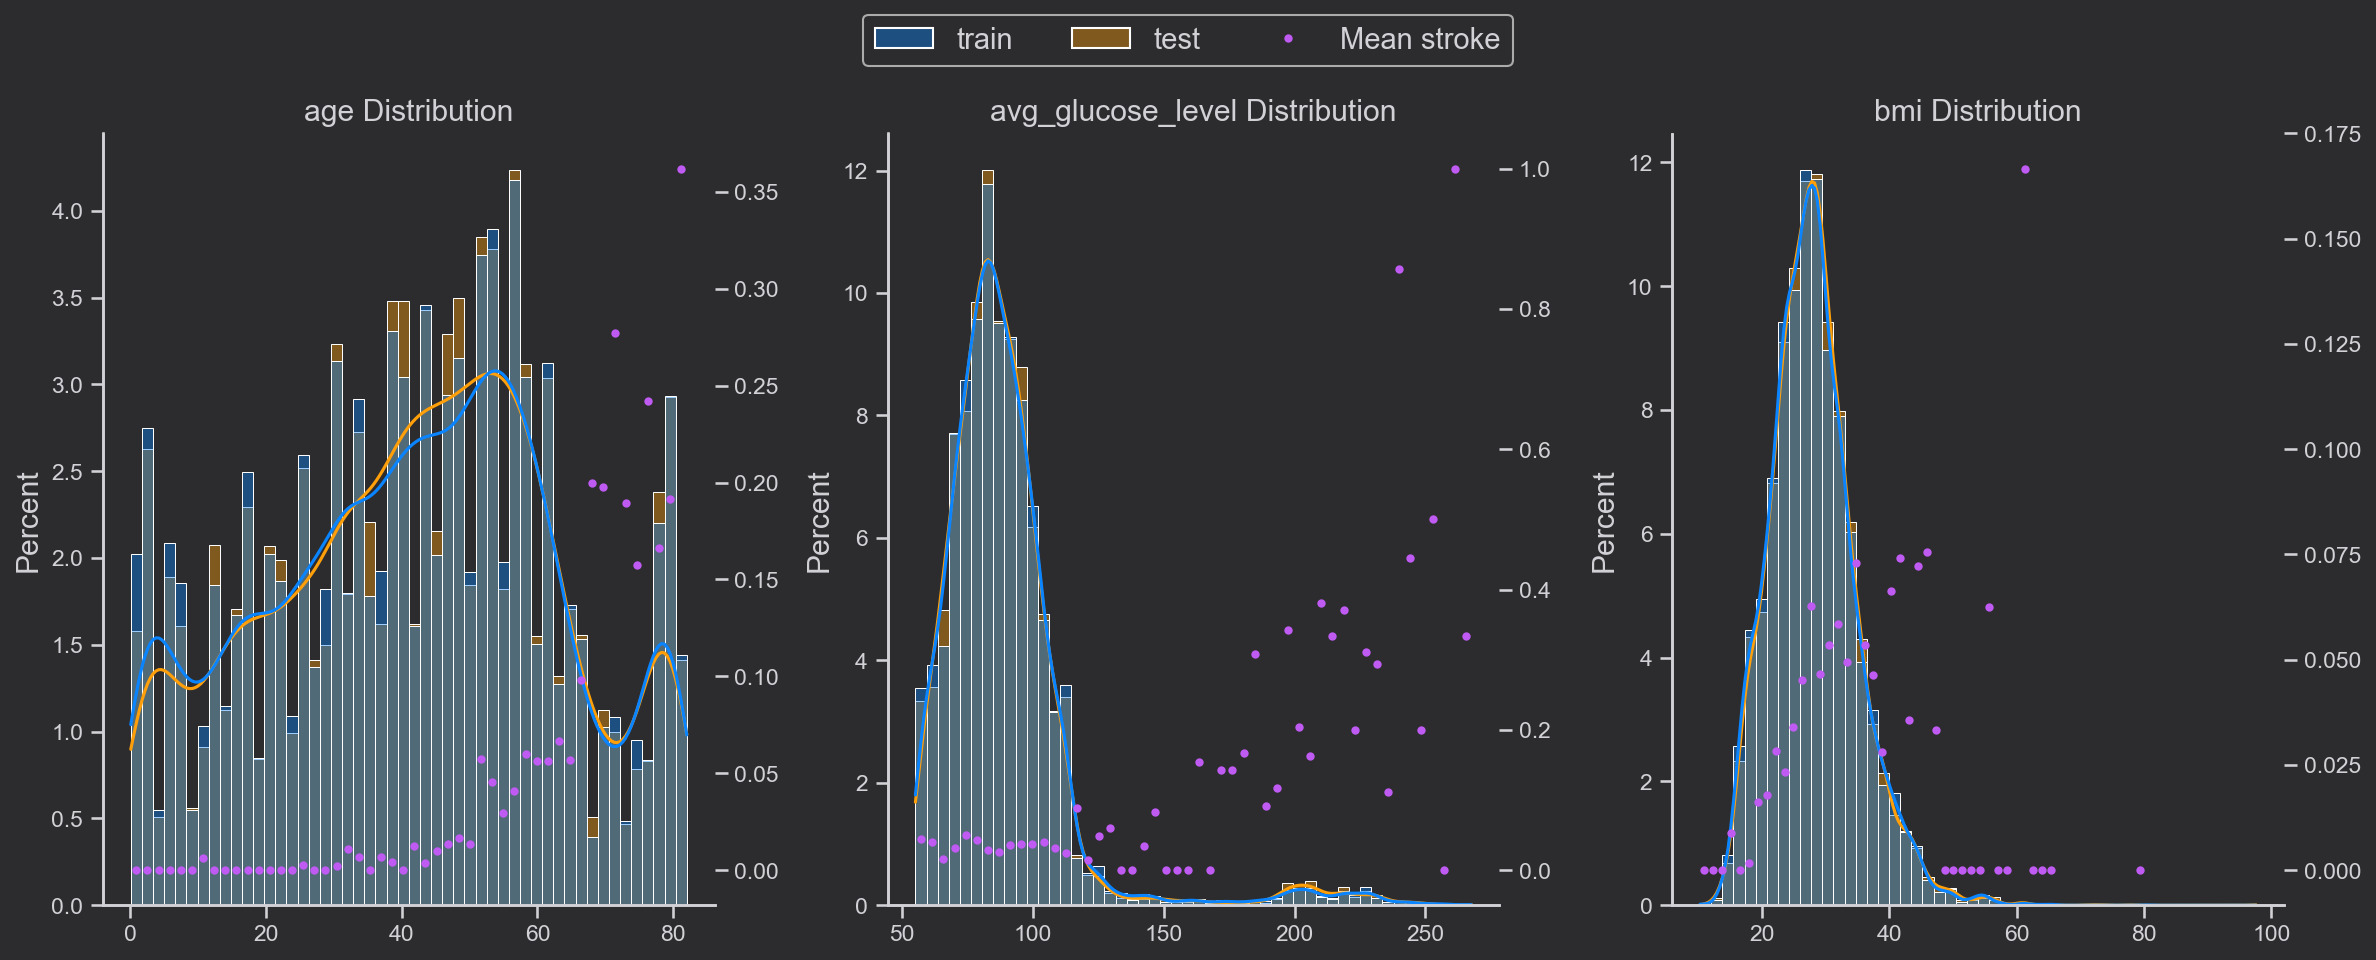

In [5]:
# auxiliary function to plot mean of target
def add_secondary_plot(
    df, column, target_column, ax, n_bins, color=3,
    show_yticks=False,):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker='.', color=colors[color], label=f'Mean {target_column}'
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

all_df = pd.concat([train_df, test_df])
all_df['set'] = 'train'
all_df.loc[all_df.index.isin(test_df.index), 'set'] = 'test'

columns = numerical_features
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.histplot(
        data=all_df,
        x=column,
        hue='set',
        common_norm=False,
        ax=ax[i],
        **histplot_hyperparams
    )
    
    # Secondary axis to show mean of target
    ax2 = add_secondary_plot(df = train_df, column=column, target_column='stroke',ax= ax[i], n_bins=n_bins, color=4, show_yticks=True)
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove legends to show only one at the end
    plot_axes = [ax[i], ax2]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
        plot_ax.legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=14, ncol=3)
plt.tight_layout()

I wanted to further check the relationship between `bmi` and stroke and found that those records with high BMI but no stroke are because people are young.

The key insight of the following plot is that **We need to consider feature interaction** either by using tree-based models or feature engineering

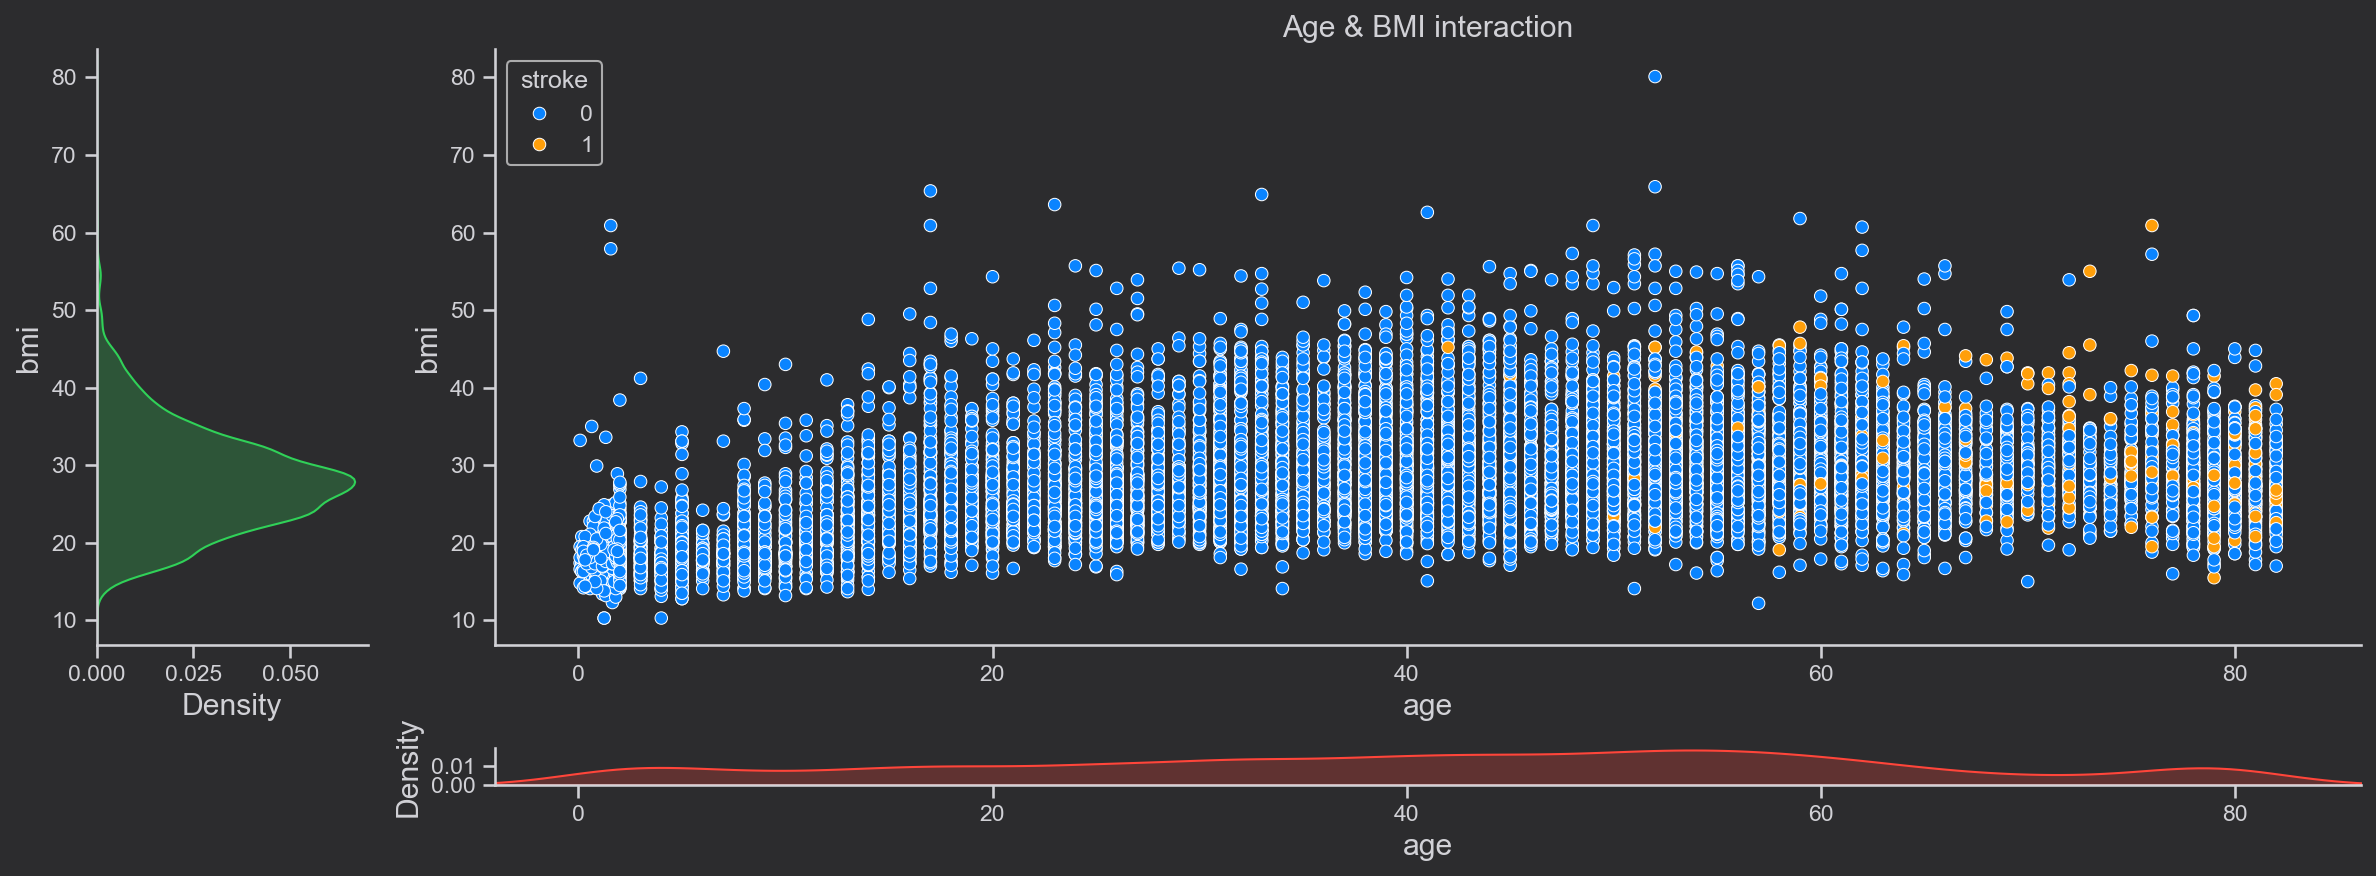

In [6]:
fig = plt.figure()
gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:5, 1:])
ax2 = fig.add_subplot(gs[:5, 0])
ax3 = fig.add_subplot(gs[5, 1:])

sns.scatterplot(x=train_df.age, y=train_df.bmi, hue=train_df.stroke, ax=ax1)
sns.kdeplot(y=train_df.bmi, ax=ax2, color=colors[2], fill=True)
sns.kdeplot(x=train_df.age, ax=ax3, color=colors[3], fill=True)

ax1.set_title('Age & BMI interaction')
legend = ax1.legend(loc='upper left')
legend.set_title('stroke')

ax2.set_ylim(ax1.get_ylim())
ax3.set_xlim(ax1.get_xlim())
plt.tight_layout()

## Categorical Features Distribution

The primary X-axes (bottom) show the percent of records that are in each set (train, and test).

**Insights**

- Strokes are morke likely when the people had hypertension, heart deseaes, or have any record of smoking.
- Train and test are the same.
- We can threath `somking==unknown` as a missing value and try different imputation strategies. This intuition is becasue that category shows a low probability of `stroke` and there may be people that smoke in the past.

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Temp\ipykernel_43332\3941102531.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor r

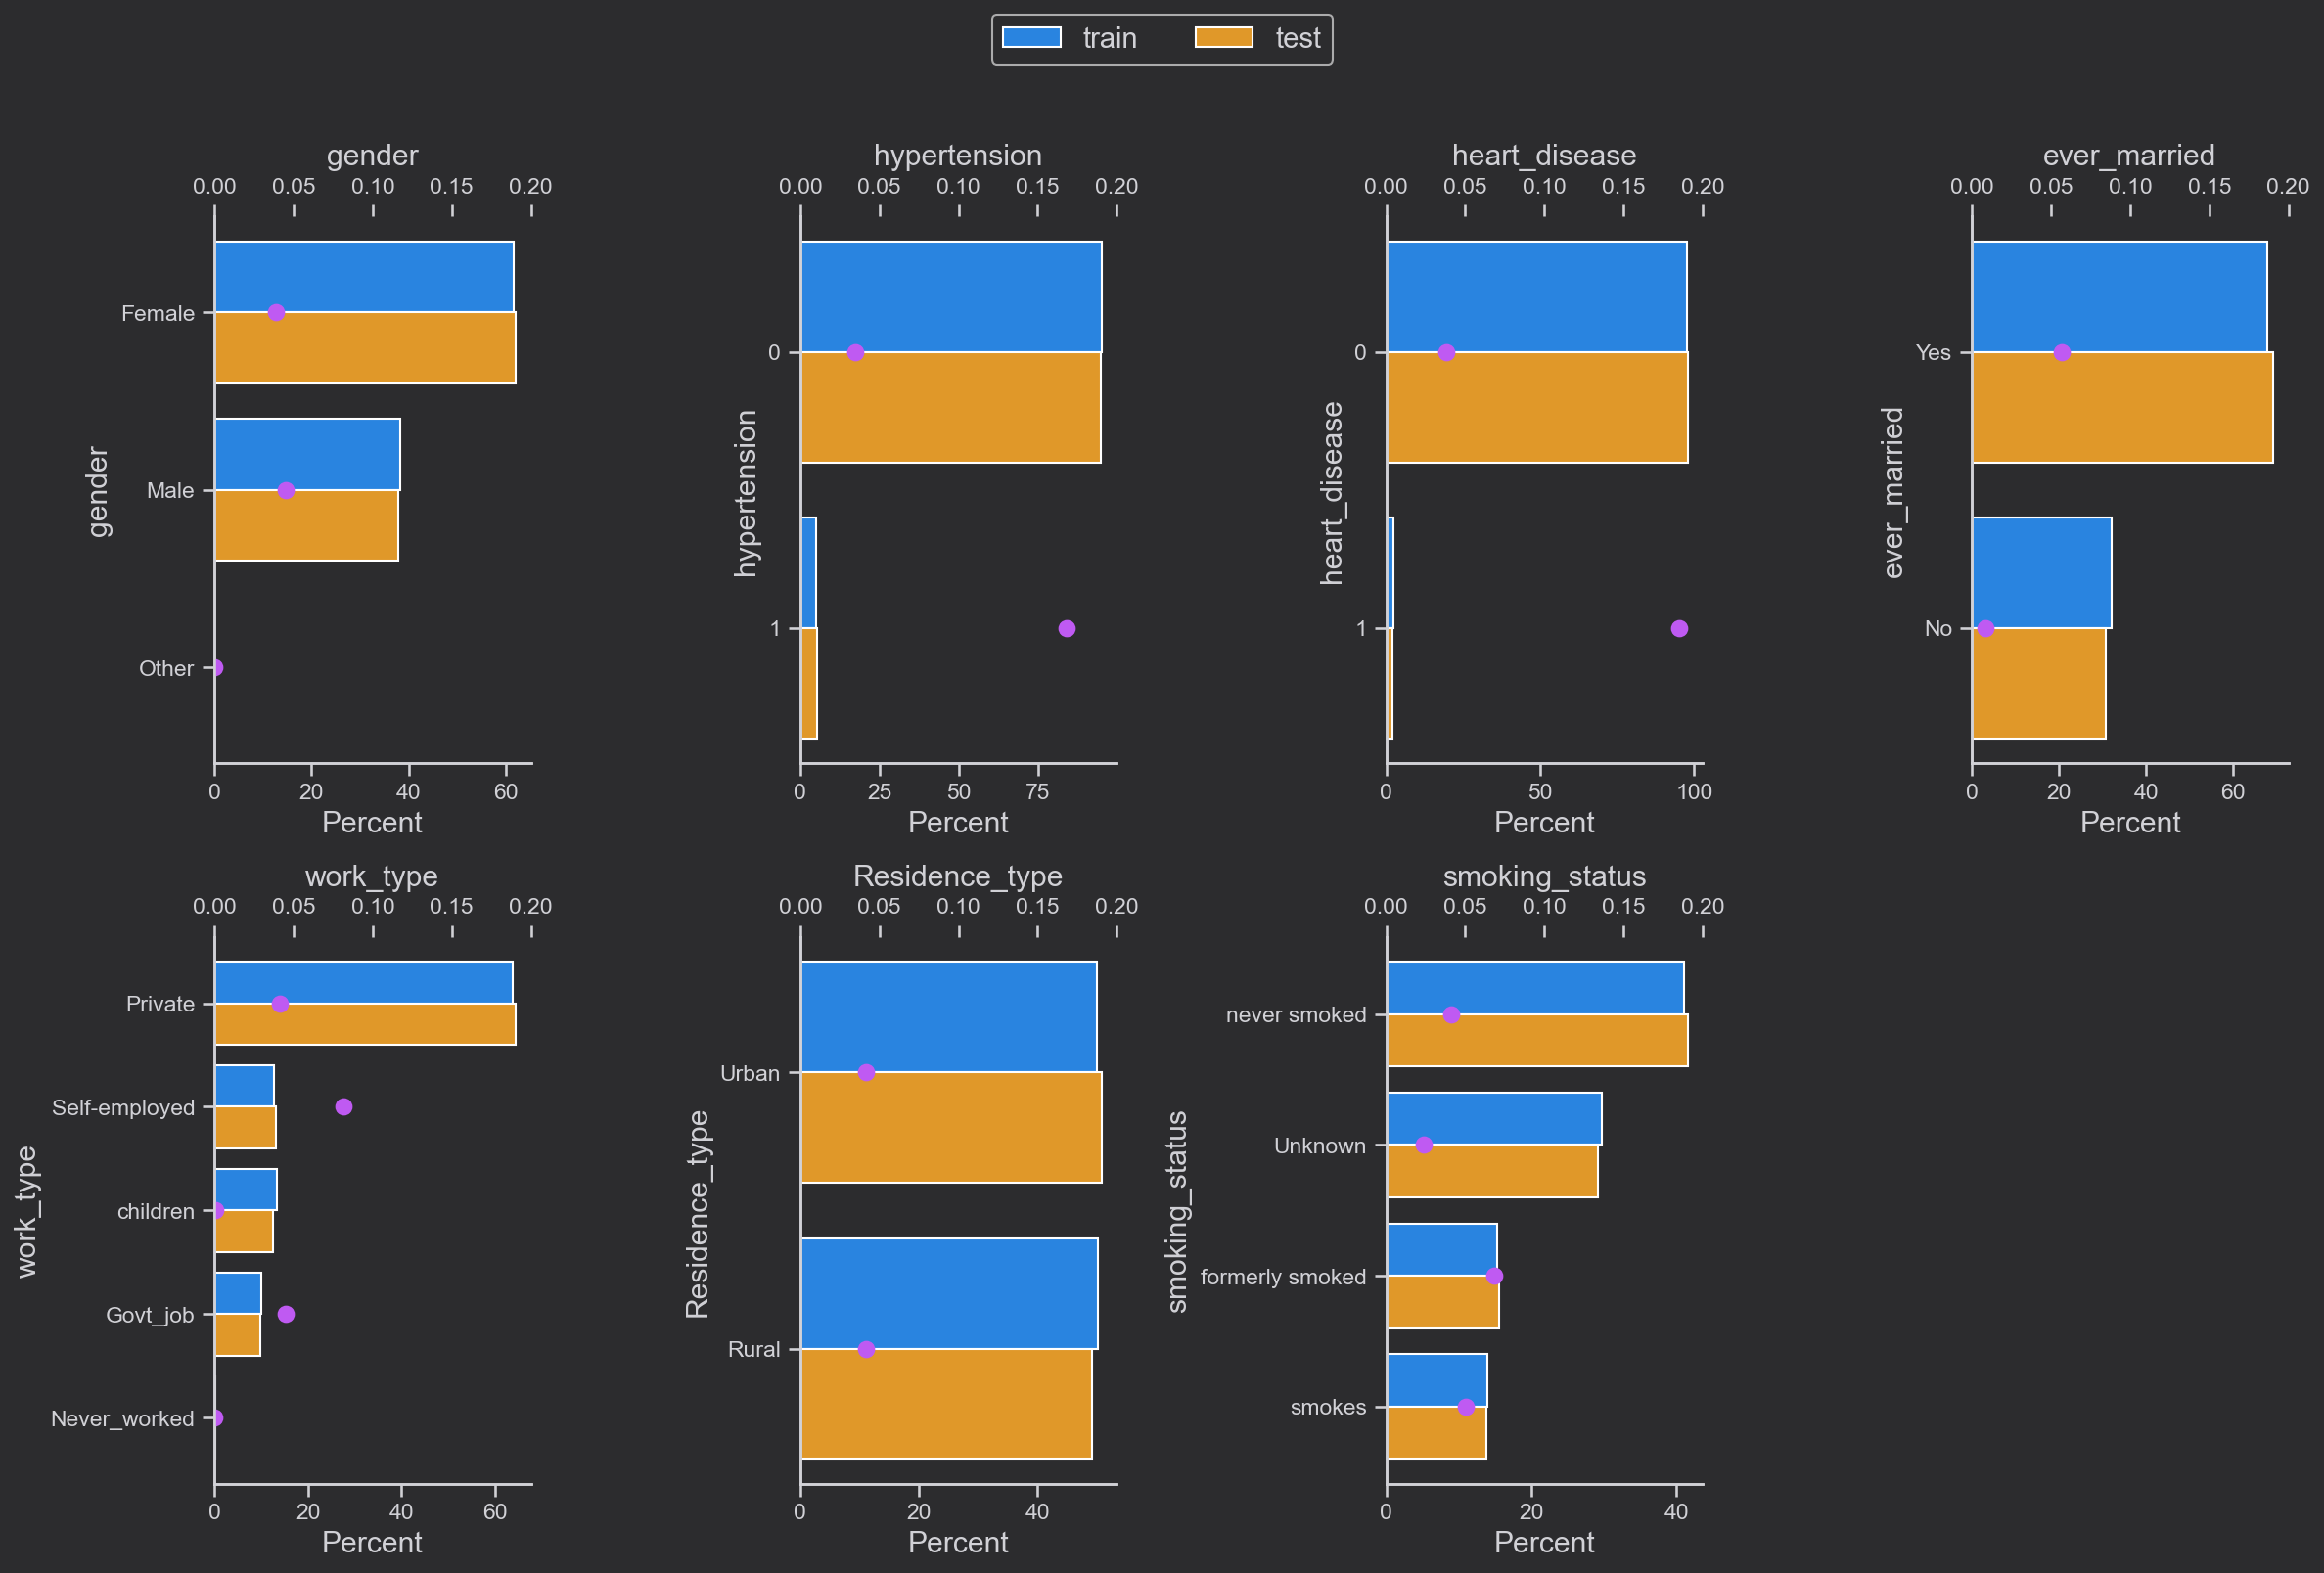

In [7]:
columns = categorical_features
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
ax = ax.flatten()

all_df = pd.concat([train_df, test_df])
all_df['set'] = 'train'
all_df.loc[all_df.index.isin(test_df.index), 'set'] = 'test'

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    data_to_plot = (
        all_df.groupby('set')[column]
        .value_counts(True)*100
    )

    sns.barplot(
        data=data_to_plot.rename('Percent').reset_index(),
        hue='set', y=column, x='Percent', ax=ax[i],
        orient='h',
        hue_order=['train', 'test']
    )
    y_ticklabels = [x.get_text() for x in ax[i].get_yticklabels()]
    
    # Secondary axis to show mean of target
    ax2 = ax[i].twiny()
    scatter_data = all_df.groupby(column)['stroke'].mean()
    scatter_data.index = scatter_data.index.astype(str)
    
    ax2.plot(
        scatter_data.loc[y_ticklabels],
        y_ticklabels,
        linestyle='', marker='.', color=colors[4],
        markersize=15
    )
    ax2.set_xlim([0, 0.2])
    
    # titles
    loc, labels = ax[i].get_xticks(), ax[i].get_xticklabels()
    ax[i].set_title(f'{column}');
    ax[i].set_xlabel('Percent')
    
    # remove axes to show only one at the end
    plot_axes = [ax[i], ax2]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
        plot_ax.legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=14, ncol=3)
ax[-1].axis('off')
plt.tight_layout()

## `smoking_status==Unknown`

status             strokes/total  pval    stat
never smoked     : 257/6281       0.880   -0.151
formerly smoked  : 159/2337       0.000   6.497
Unknown          : 108/4543       0.000   -5.936
smokes           : 108/2143       0.034   2.117



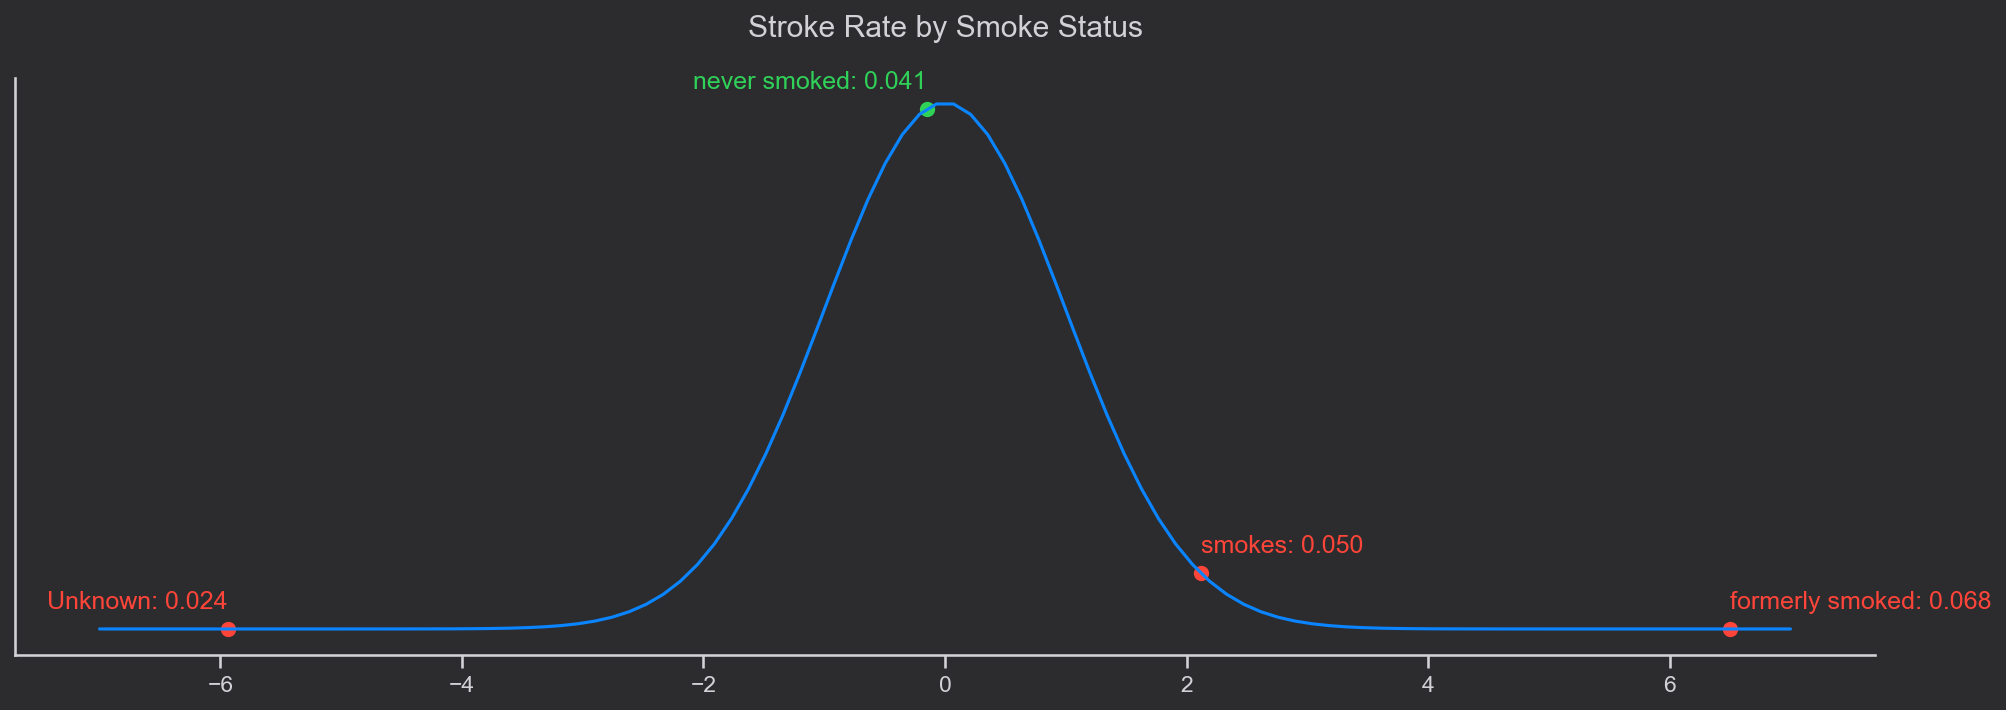

<Figure size 2400x900 with 0 Axes>

In [8]:
from statsmodels.stats.proportion import proportions_ztest
import scipy

plt.figure(figsize=(16, 5))
z_ticks = np.linspace(-7, 7, 100)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

print(f'{"status":16}   strokes/total  pval    stat')
stroke_mean = train_df.stroke.mean()
for status in train_df.smoking_status.unique():
    df = train_df[train_df.smoking_status.eq(status)]
    total = df.shape[0]
    strokes = df.stroke.sum()
    
    z, pval = proportions_ztest(strokes, total, stroke_mean, prop_var=stroke_mean)
    print(f'{status:16} : {strokes}/{total}       {pval:.3f}   {z:.3f}')
    plt.scatter([z], [scipy.stats.norm.pdf(z)], c=colors[3] if abs(z) > 2 else colors[2], s=40)
    plt.annotate(
        f"{status}: {strokes / total:.3f}",
        (z, scipy.stats.norm.pdf(z)),
        xytext=(0,10), 
        textcoords='offset points', ha='left' if z > 0 else 'right',
        color=colors[3] if abs(z) > 2 else colors[2]
    )
    
print()
plt.title('Stroke Rate by Smoke Status', pad=20)
plt.yticks([])
plt.show()
plt.tight_layout()

In [9]:
# from statsmodels.stats.proportion import proportions_ztest

# df_with_status = train_df[train_df.smoking_status.ne('Unknown')]
# df_without_status = train_df[train_df.smoking_status.eq('Unknown')]

# counts = [
#     df_with_status.stroke.sum(),
#     df_without_status.stroke.sum()
# ]

# nobs = [
#     df_with_status.shape[0],
#     df_without_status.shape[0]
# ]

# z, pval = proportions_ztest(counts, nobs)
# print(pval)

## Numerical Train vs Original Dataset

**Insight**
- Synthetic generated features doesn't share the same distribution as SPD. Similar to the past playground series, beaware of difference if augmenting the dataset.
- No significant differences when checking the relationship with target column

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

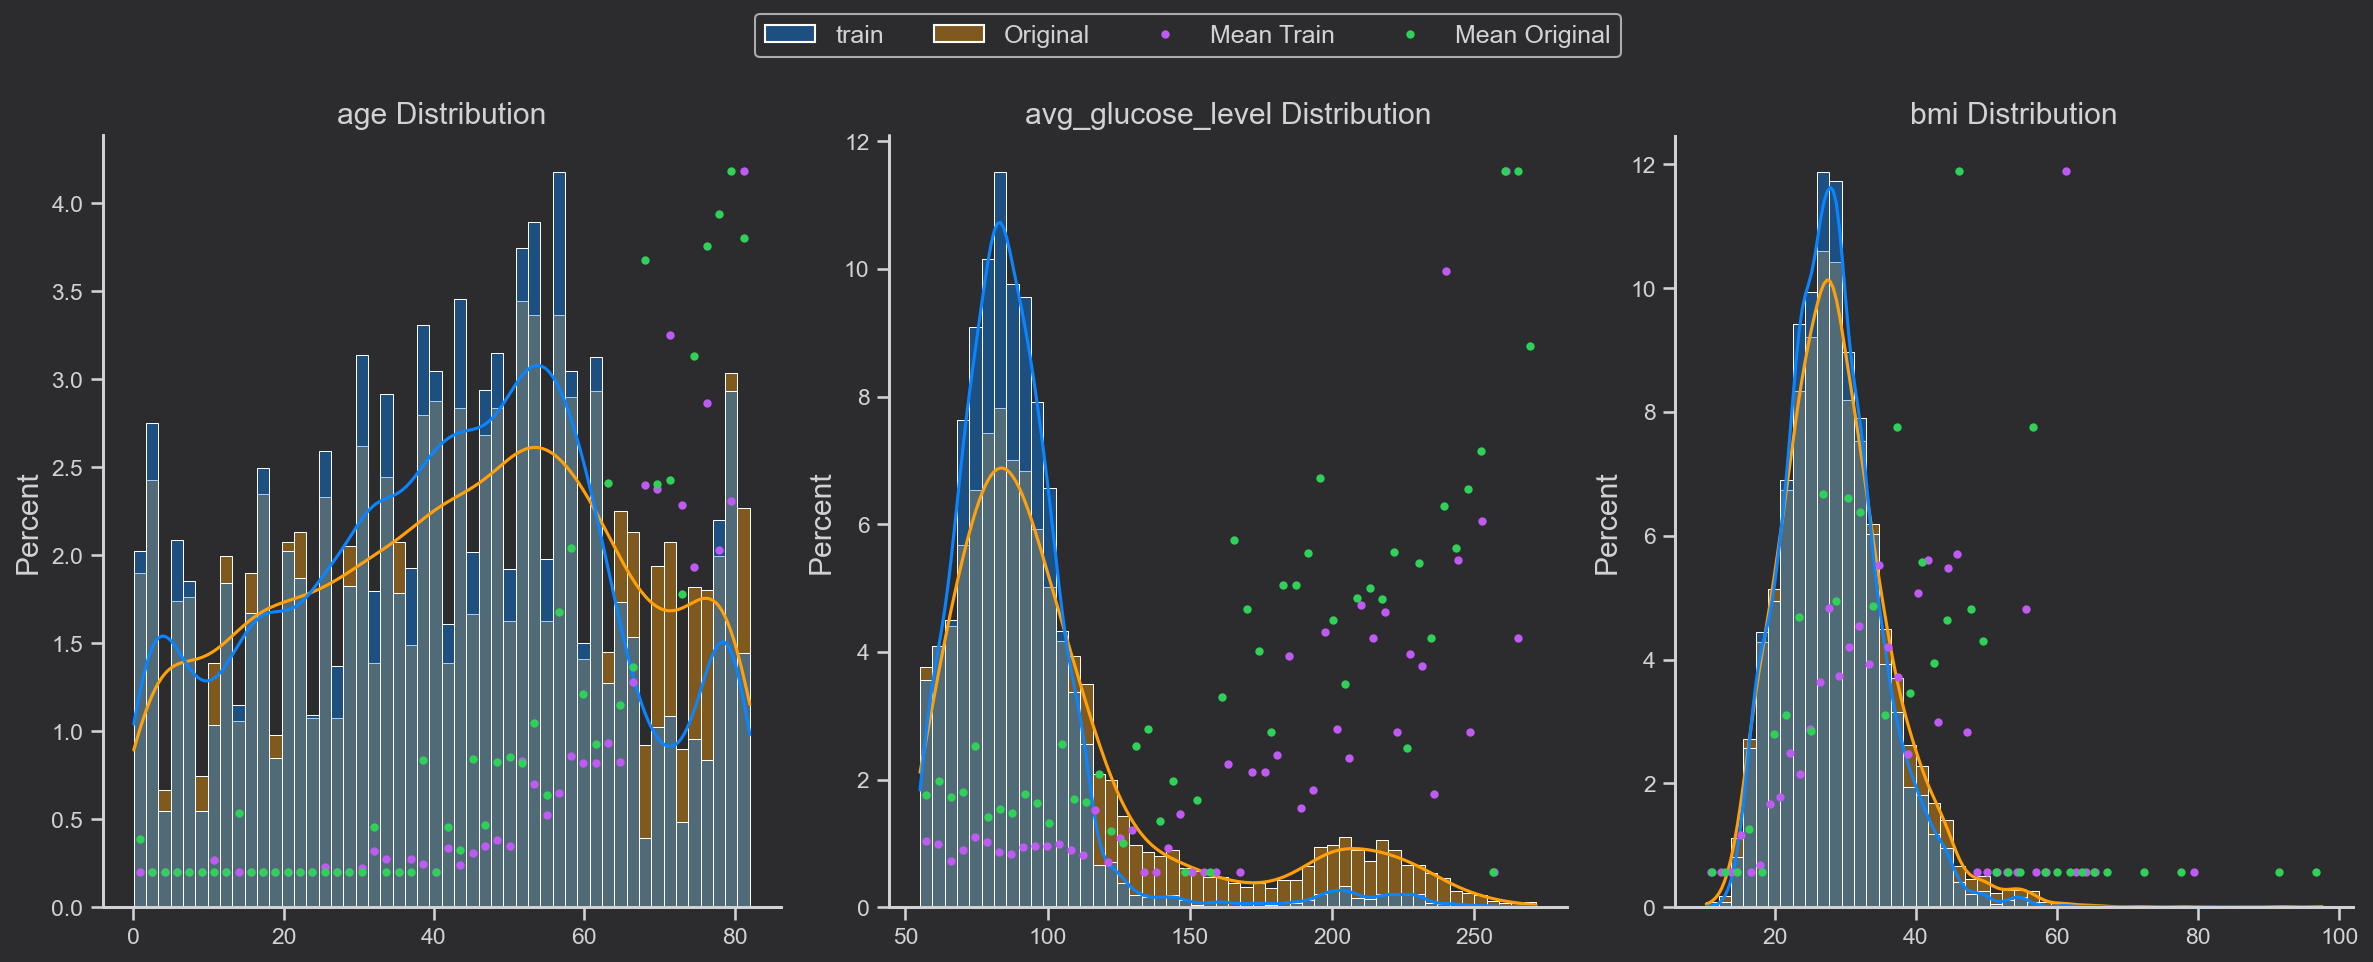

In [10]:
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = numerical_features
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax = ax.flatten()

all_df = pd.concat([train_df, original_df])
all_df['set'] = 'train'
all_df.iloc[train_df.shape[0]:, -1] = 'original'
all_df.reset_index(drop=True, inplace=True)

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.histplot(
        data=all_df,
        x=column,
        hue='set',
        common_norm=False,
        ax=ax[i],
        **histplot_hyperparams,
        hue_order=['train', 'original']
    )
    
    # Secondary axis to show mean of target
    ax2 = add_secondary_plot(train_df, column, 'stroke', ax[i], n_bins, color=4)
    ax3 = add_secondary_plot(original_df, column, 'stroke', ax[i], n_bins, color=2)
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove legend to show only one at the end
    plot_axes = [ax[i], ax2, ax3]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
        plot_ax.legend().remove()
    
labels = ['train', 'Original', 'Mean Train', 'Mean Original']
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=12, ncol=4)
plt.tight_layout()

## Categorical Train vs Original Dataset


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Temp\ipykernel_43332\3469887401.py:62: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor r

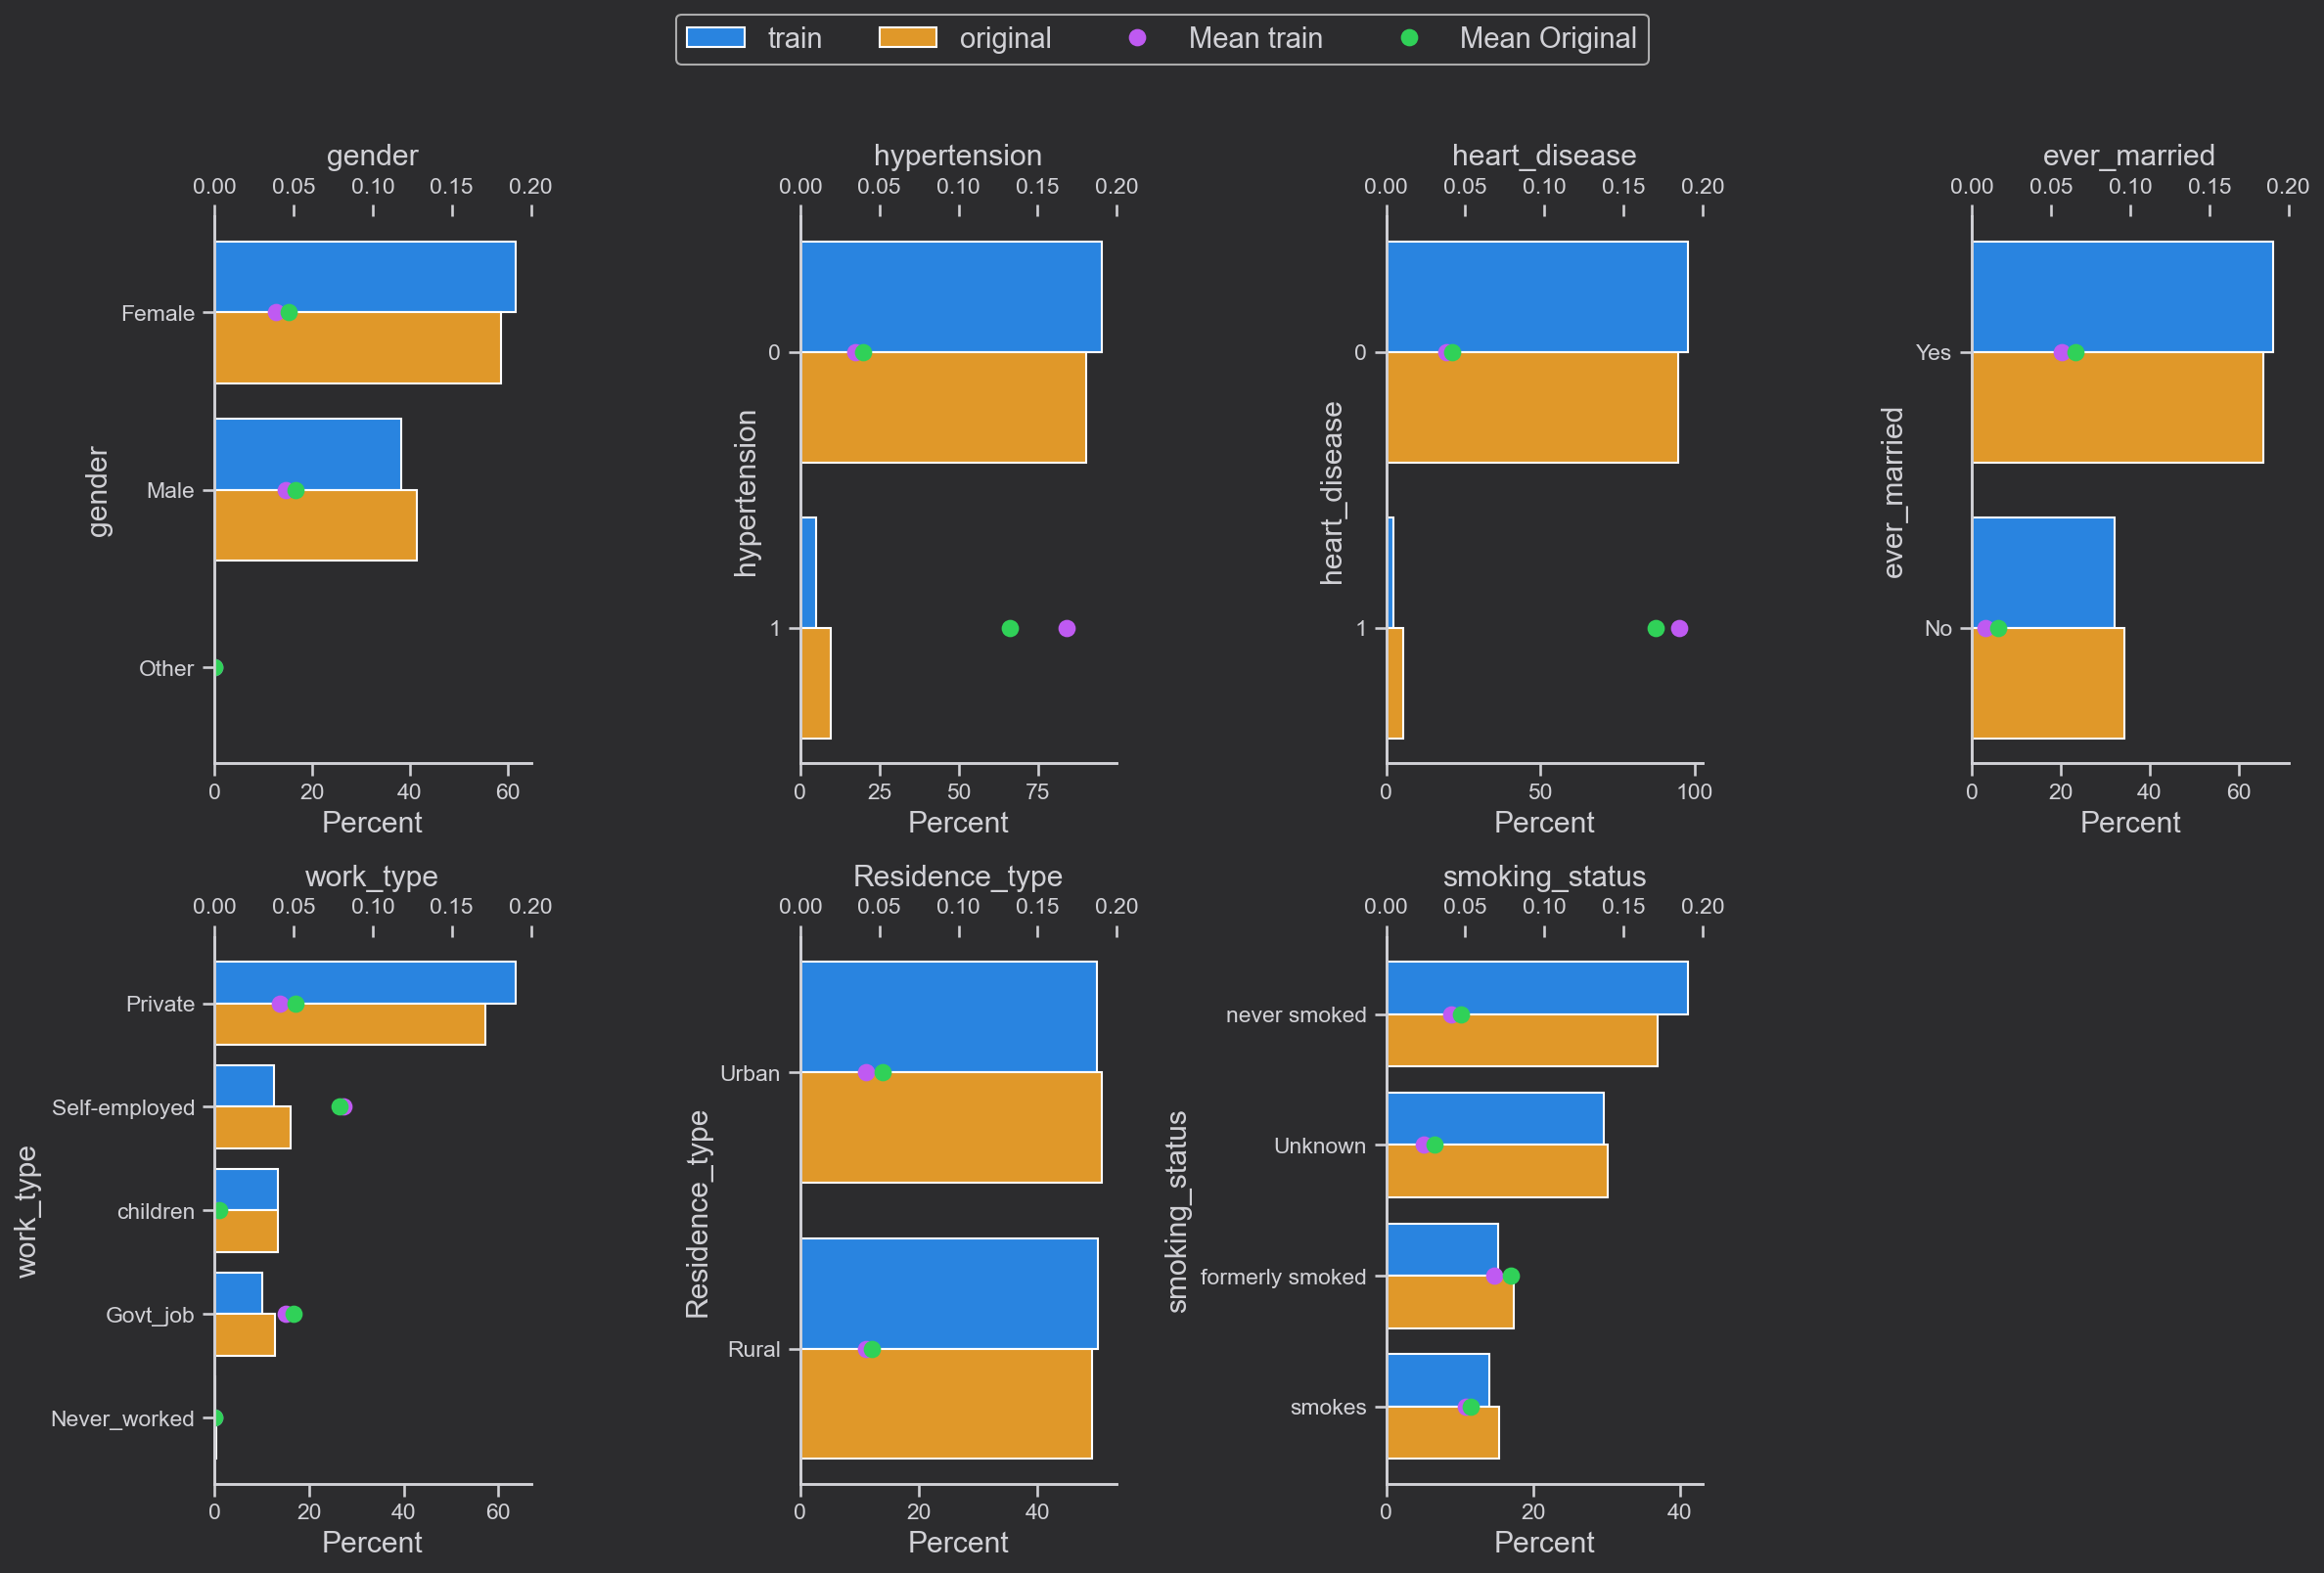

In [11]:
columns = categorical_features
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
ax = ax.flatten()

all_df = pd.concat([train_df, original_df])
all_df['set'] = 'train'
all_df.iloc[train_df.shape[0]:, -1] = 'original'

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    data_to_plot = (
        all_df.groupby('set')[column]
        .value_counts(True)*100
    )

    sns.barplot(
        data=data_to_plot.rename('Percent').reset_index(),
        hue='set', y=column, x='Percent', ax=ax[i],
        orient='h',
        hue_order=['train', 'original']
    )
    y_ticklabels = [x.get_text() for x in ax[i].get_yticklabels()]
    
    # Secondary axis to show mean of target
    ax2 = ax[i].twiny()
    
    train_scatter_data = (train_df.groupby(column)['stroke'].mean())
    train_scatter_data.index = train_scatter_data.index.astype(str)
    
    original_scatter_data = (original_df.groupby(column)['stroke'].mean())
    original_scatter_data.index = original_scatter_data.index.astype(str)
    
    ax2.plot(
        train_scatter_data.loc[y_ticklabels],
        y_ticklabels,
        linestyle='', marker='.', color=colors[4],
        markersize=15,
        label='Mean train'
    )
    
    ax2.plot(
        original_scatter_data.loc[y_ticklabels],
        y_ticklabels,
        linestyle='', marker='.', color=colors[2],
        markersize=15,
        label='Mean Original'
    )
    
    ax2.set_xlim([0, 0.2])
    
    # titles
    loc, labels = ax[i].get_xticks(), ax[i].get_xticklabels()
    ax[i].set_title(f'{column}');
    ax[i].set_xlabel('Percent')
    
    # remove legend to show only one at the end
    plot_axes = [ax[i], ax2]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), fontsize=14, ncol=4)
ax[-1].axis('off')
plt.tight_layout()

# Features Correlations

The nature of our features will select the type of correlation we should calculate between each pair. For the following plots I'm using [dython](http://shakedzy.xyz/dython/modules/nominal/#nominal) implementation to grab associations between features according to their nature:

* [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between for continous-continous pairs.
* [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) with bias correction for categorical-categorical.
* [Correlation Ratio](https://en.wikipedia.org/wiki/Correlation_ratio) for categorical-continous.

---
**Insights**:
- The correlations matrix between train and SPD are different. This is by no means a surprise give that in previous plots, the distribution difference is evident.
- No strong correlations for continous-continous pairs, no need to drop features for linear models.

**Disclaimer**: Relationships between categorical-continous are in the range of [0, 1], so the interpretation is not the same as pearson's correlation coefficient.

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dython\nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dython\nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python3

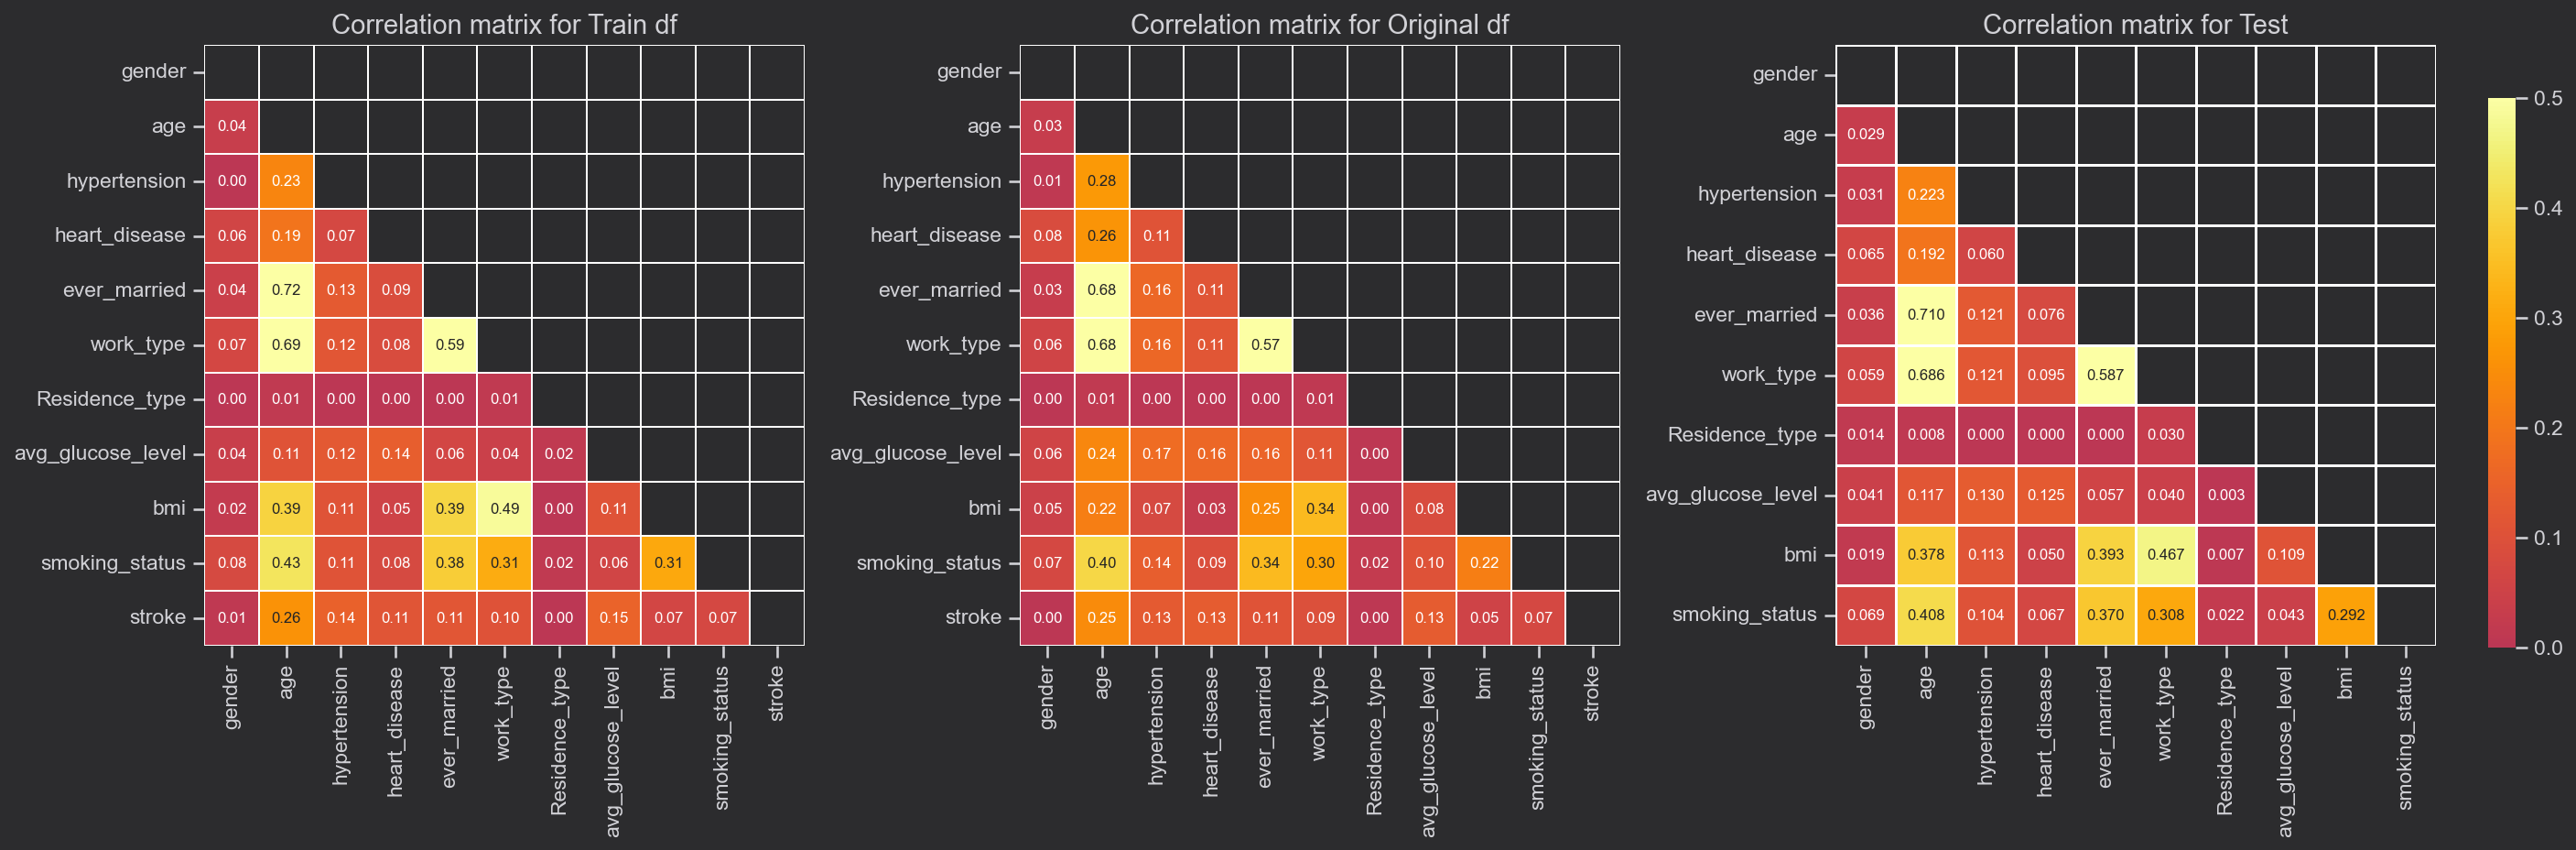

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
float_types = [np.float16, np.float32, np.float64]
float_columns = train_df.select_dtypes(include=float_types).columns
cbar_ax = fig.add_axes([.91, .39, .01, .2])
vmax, vmin = 0.5, 0

names = ['Train', 'Original']
for i, df in enumerate([train_df, original_df]):
    
    corr = associations(
        df, numerical_columns=numerical_features,
        nominal_columns=categorical_features,
        compute_only=True,
        plot=False
    )['corr']
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(
        corr, mask=mask, cmap='inferno',
        vmax=vmax, vmin=vmin,
        center=0, annot=True, fmt='.2f',
        square=True, linewidths=.1,
        ax=ax[i],
        cbar=False,
        cbar_ax=None,
        annot_kws={"size": 8}
    )

    ax[i].set_title(f'Correlation matrix for {names[i]} df', fontsize=14)

df = test_df
float_columns = test_df.select_dtypes(include=float_types).columns
corr = associations(
    test_df, numerical_columns=numerical_features,
    nominal_columns=categorical_features,
    compute_only=True,
    plot=False
)['corr']
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, mask=mask, cmap='inferno',
    vmax=vmax, vmin=vmin,
    center=0, annot=True, fmt='.3f',
    square=True, linewidths=.5,
    cbar_kws={"shrink":.5, 'orientation':'vertical'},
    ax=ax[2],
    cbar=True,
    cbar_ax=cbar_ax,
    annot_kws={"size": 8}
)
ax[2].set_title(f'Correlation matrix for Test', fontsize=14)
fig.tight_layout(rect=[0, 0, .9, 1])

# Baseline


I'll be using [feature-engine](https://feature-engine.readthedocs.io/) because the syntax is similar to sklearn's and it has additional features when using encoders on dataframes.

You may also try for different encoder:

**[Mean Encoder](https://feature-engine.readthedocs.io/en/latest/api_doc/encoding/MeanEncoder.html)**:
```Python
from feature_engine.encoding import TargetEncoder
encoder = MeanEncoder(variables=categorical_features)
```
**[Weights Of Evidence](https://feature-engine.readthedocs.io/en/latest/api_doc/encoding/WoEEncoder.html)**:
```Python
from feature_engine.encoding import WoEEncoder
encoder = WoEEncoder(variables=categorical_features)
```

**[Count Frequency Encoder](https://feature-engine.readthedocs.io/en/latest/api_doc/encoding/CountFrequencyEncoder.html)**
```Python
from feature_engine.encoding import CountFrequencyEncoder
encoder = CountFrequencyEncoder(variables=categorical_features, encoding_method='frequency')
```

In [13]:
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(shuffle=True, random_state=2023)
all_features = numerical_features + categorical_features

# Create a copy of train df to modify inplace
train_df_ = train_df[all_features].copy()

# cast categorical features as categorical type
train_df_[categorical_features] = (
    train_df_[categorical_features].astype('category')
)

target = train_df['stroke']

oof_preds = pd.Series(0, index=train_df.index)
start = time()
tr_auc = []
vl_auc = []
pipelines = []

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    
    X_tr = X_tr.copy()
    X_vl = X_vl.copy()
    
    model = LogisticRegression()
    encoder = OneHotEncoder(drop_last=True, variables=categorical_features)
    scaler = SklearnTransformerWrapper(StandardScaler(), variables=numerical_features)
    
    X_tr = encoder.fit_transform(X_tr)
    X_tr = scaler.fit_transform(X_tr)
    
    X_vl = encoder.transform(X_vl)
    X_vl = scaler.transform(X_vl)

    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')
    
    model.fit(X_tr, y_tr)
    
    oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]
    tr_auc.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
    vl_auc.append(roc_auc_score(y_vl, model.predict_proba(X_vl)[:, 1]))
    pipelines.append([encoder, scaler, model])

    print(f'Val AUC: {Fore.BLUE}{vl_auc[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val AUC: {Fore.GREEN}{np.mean(vl_auc)}{Style.RESET_ALL}')
print(f'OOF AUC:      {Fore.GREEN}{roc_auc_score(target, oof_preds)}{Style.RESET_ALL}')

__________________________________________________
Fold 0 | 0:00:00
Val AUC: 0.8833536140180093
__________________________________________________
Fold 1 | 0:00:00
Val AUC: 0.8786133419864255
__________________________________________________
Fold 2 | 0:00:00
Val AUC: 0.8774482177457879
__________________________________________________
Fold 3 | 0:00:00
Val AUC: 0.8754407999613544


C:\Users\ilias\AppData\Local\Temp\ipykernel_43332\800238279.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01457984 0.0016625  0.02269491 ... 0.19498792 0.0004516  0.10666825]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]


__________________________________________________
Fold 4 | 0:00:00
Val AUC: 0.9063335172742126

Mean Val AUC: 0.8842378981971579
OOF AUC:      0.8838311888312191


C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

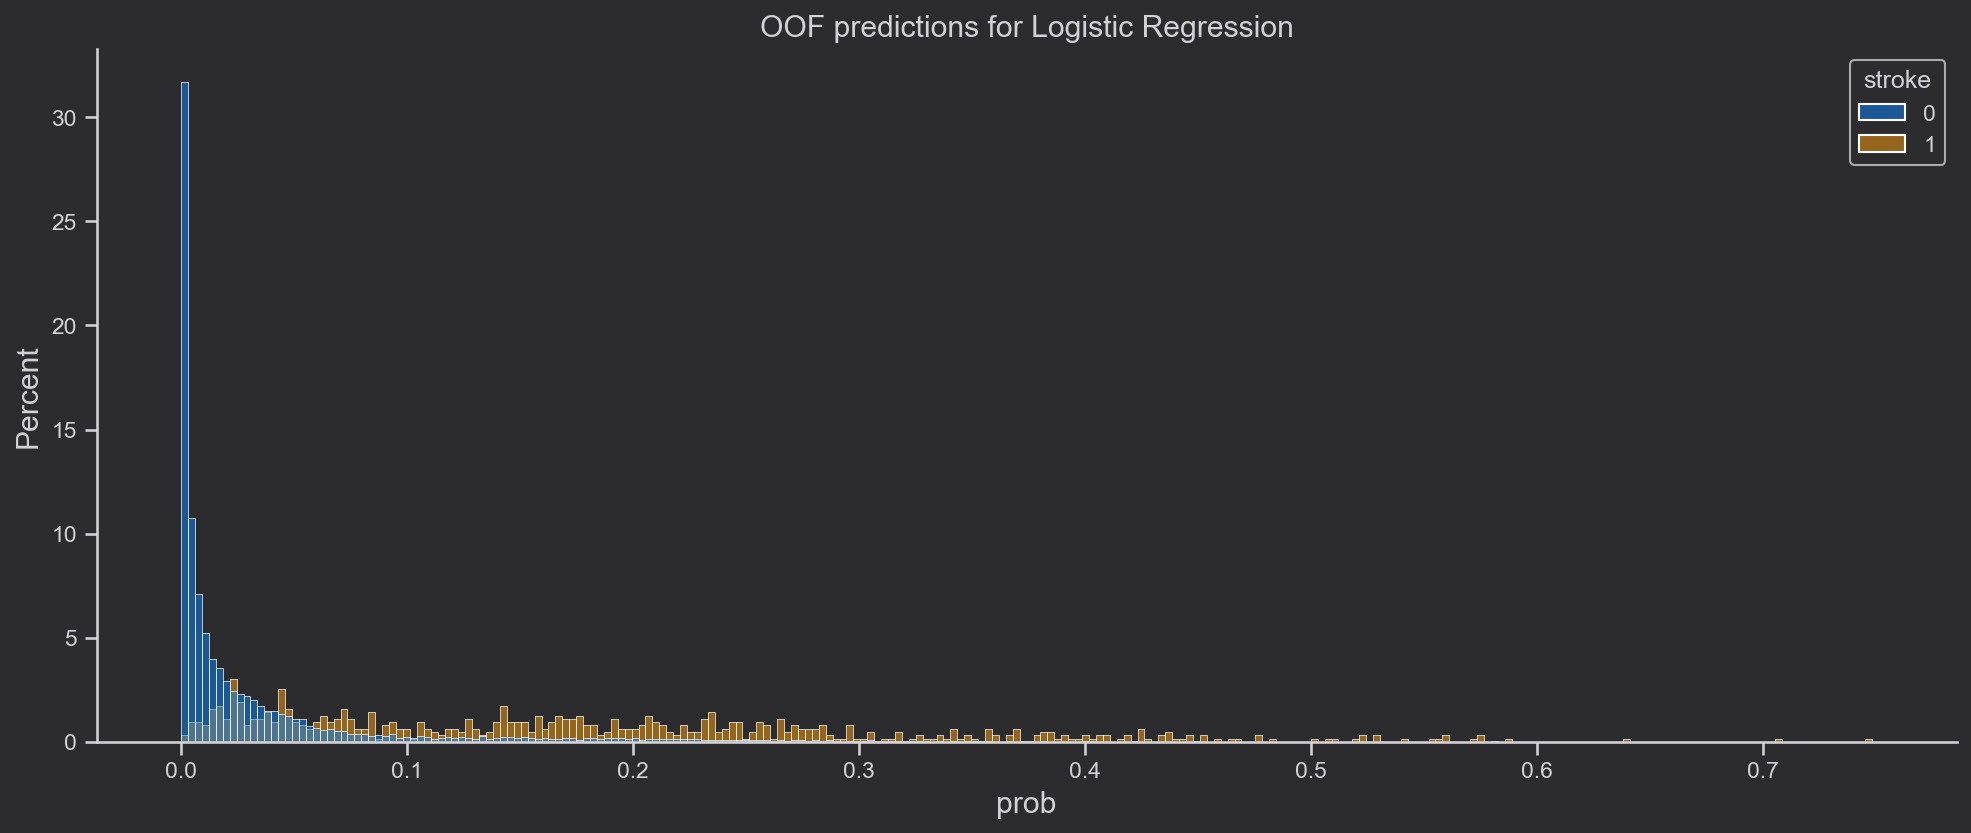

In [14]:
ax = sns.histplot(
    data=oof_preds.to_frame(name='prob').join(target),
    hue='stroke',
    x='prob',
    stat='percent',
    common_norm=False
)
ax.set_title('OOF predictions for Logistic Regression');

In [15]:
from sklearn.metrics import average_precision_score
from scipy.stats import ks_2samp

In [16]:
ks_2samp(oof_preds[target==0], oof_preds[target==1])

KstestResult(statistic=0.6132700882072801, pvalue=1.2395546832231673e-219, statistic_location=0.04339798881488582, statistic_sign=1)

# Generate Test Submission

In [17]:
preds = pd.Series(0, index=test_df.index)
X_test = test_df[all_features].copy()

for pipeline in pipelines:
    X_test = test_df[all_features].copy()
    encoder, scaler, model = pipeline
    X_test = encoder.transform(X_test)
    X_test = scaler.transform(X_test)
    preds += model.predict_proba(X_test)[:, 1]

preds /= len(pipelines)
preds.rename('stroke', inplace=True)
preds.to_csv('submission.csv')

## Plot oof preds & test preds

C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\ilias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping 

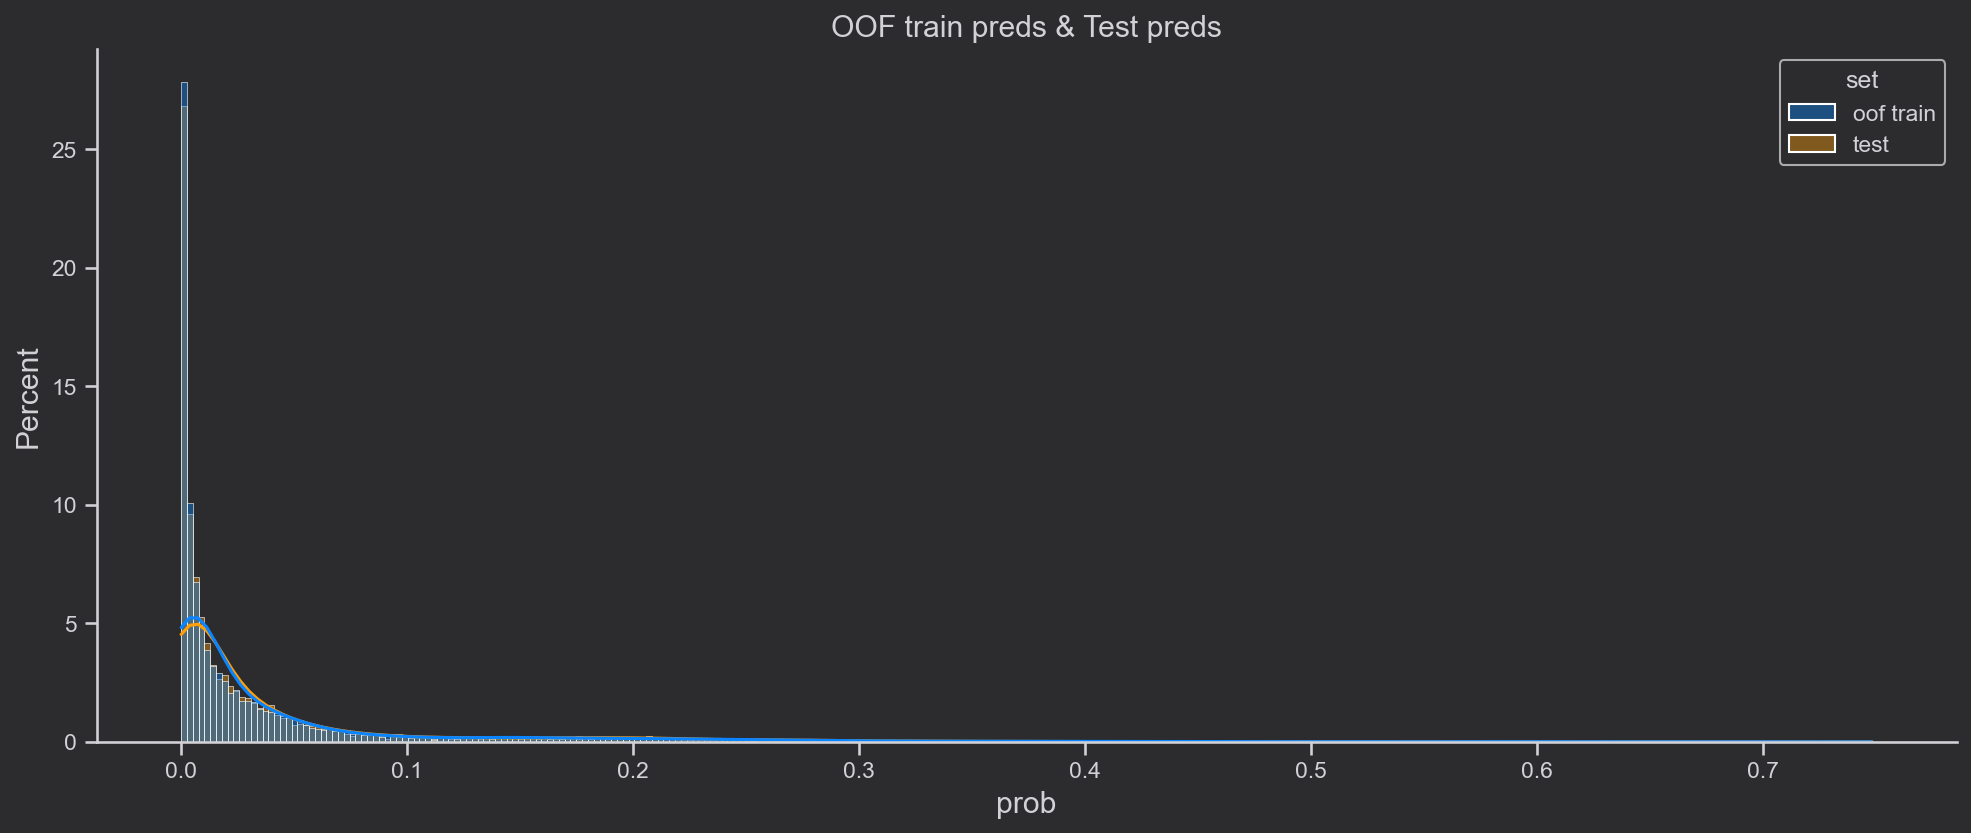

In [18]:
df = pd.concat([
    oof_preds.to_frame('prob'),
    preds.to_frame('prob')
])

df['set'] = 'oof train'
df.loc[df.index.isin(preds.index), 'set'] = 'test'

ax = sns.histplot(
    data=df, hue='set', x='prob', common_norm=False,
    stat='percent', color=colors[0], alpha=0.4,
    kde=True
)

ax.set_title('OOF train preds & Test preds');

## Feature Importance

**Insights**
- For a linear model, `age`, `bmi`, and `glucose_level` are the features that contribute the most to having a stroke.
- Not having a pre-existing condition is the factor that contributes to prevent a stroke.

C:\Users\ilias\AppData\Local\Temp\ipykernel_43332\2988593946.py:23: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  ax = sns.barplot(


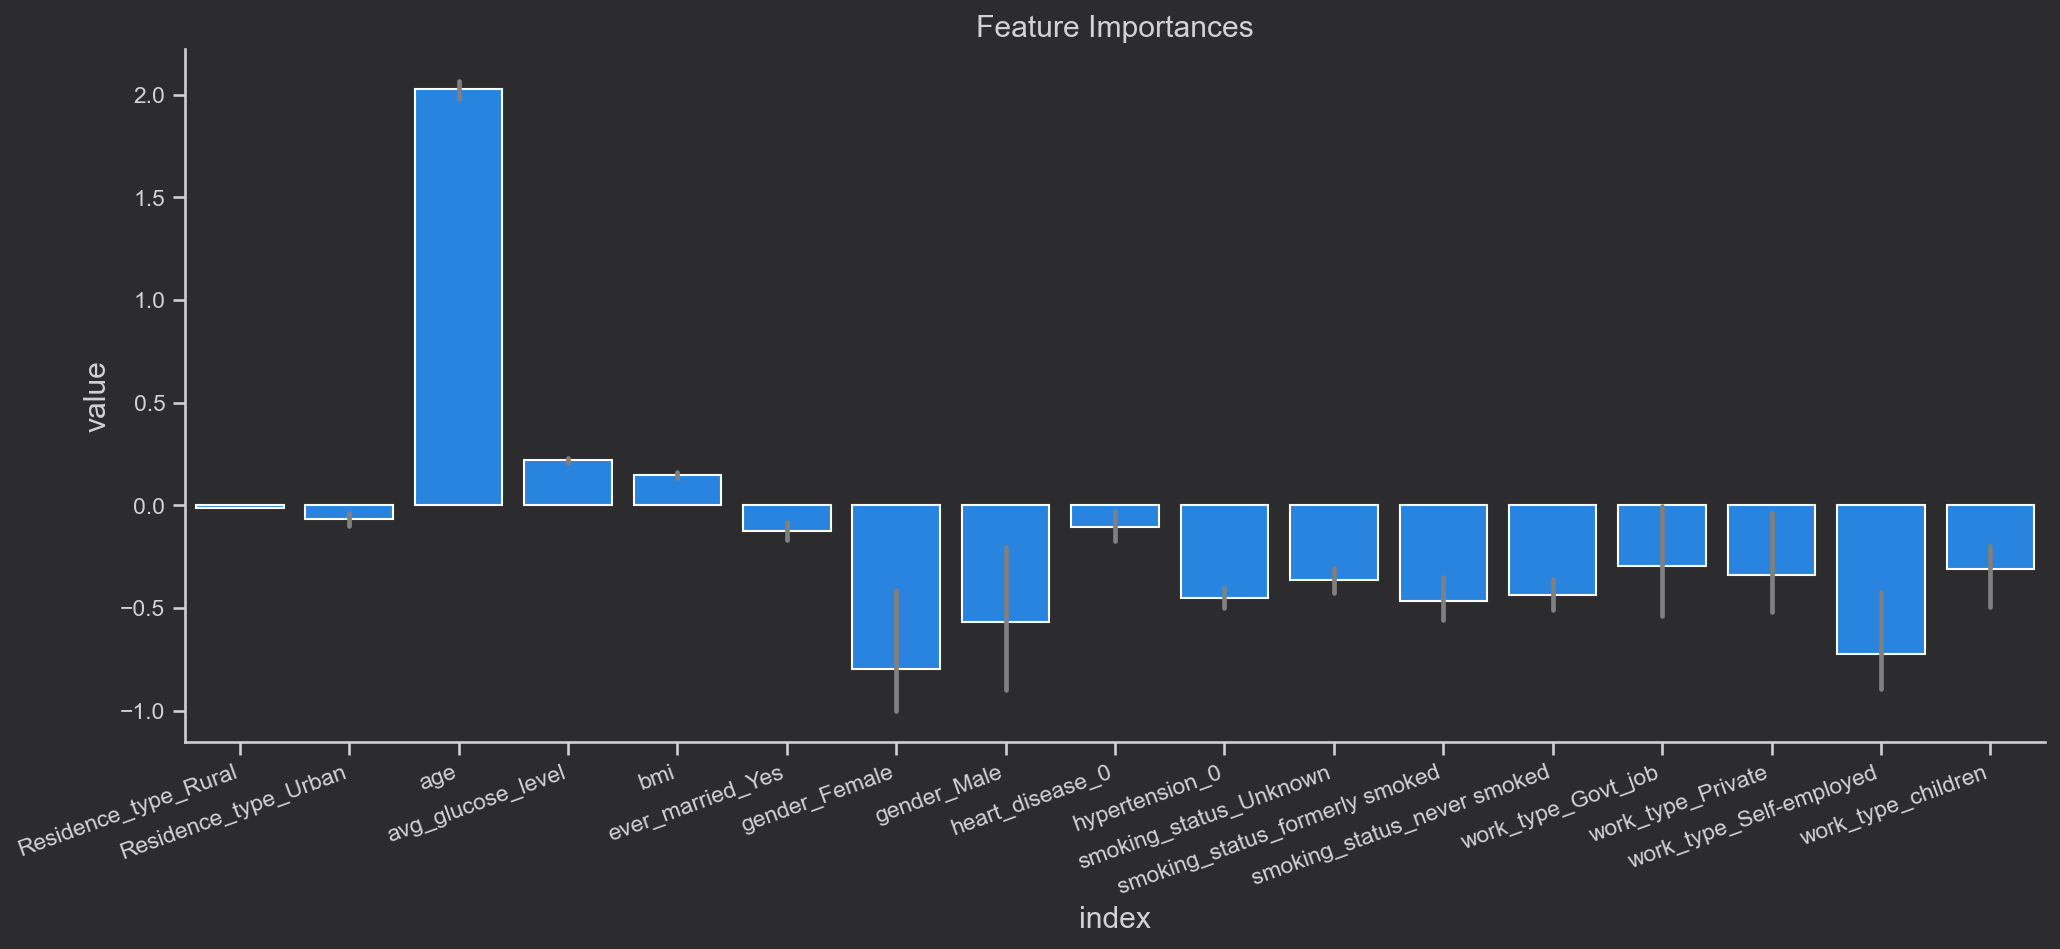

In [19]:
preds = pd.Series(0, index=test_df.index)
train_df_ = train_df[all_features].copy()

importances = {}

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
    encoder, scaler, model = pipelines[fold]
    X_tr, y_tr = train_df_.iloc[tr_ix].copy(), target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix].copy(), target.iloc[vl_ix]
    
    X_tr = encoder.transform(X_tr)
    X_tr = scaler.transform(X_tr)
    
    #Grab the columns post sklearn transformers
    columns = X_tr.columns
    model_importances = pd.Series(model.coef_.flatten(), index=X_tr.columns)
    importances[fold] = model_importances
    
importances_df = pd.DataFrame(importances)
importances_df.columns = [f'fold_{x}' for x in range(len(pipelines))]

#Plot importances
ax = sns.barplot(
    data=pd.melt(importances_df.reset_index(), id_vars='index'),
    x='index', y='value', errcolor='.5'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.set_title('Feature Importances');

# Replicate Some of the best submissions

My final code scored 5th on the private leaderboard. In this section I'll share the code to train the XGBoost model (best single model) that was used on my final ensemble. Additionaly, the code I used to find the ensemble weight using gradient descent.

In [20]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension*df.heart_disease
    return df

In [22]:
original_df = pd.read_csv(
    'healthcare-dataset-stroke-data.csv',
    index_col=0
)

train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

rfe_features =[
    'age', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'gender_Male',
    'hypertension_0', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
    'smoking_status_never smoked', 'work_type_Self-employed', 'work_type_children'
]

cat_features = [
    'gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type', 'smoking_status',
    'blood_heart'
]

num_features = [
    'age', 'bmi', 'avg_glucose_level',
    'age/bmi', 'age*bmi', 'bmi/prime', 'obesity'
]

fe_features = ['blood_heart', 'age/bmi', 'age*bmi', 'bmi/prime', 'obesity']
all_features = cat_features + num_features

## Define configurations for this run

I normally use a CFG dictionary to log the run on WANDB and have a pipeline for quick iterations of ideas. For the sake of simplicity, this code doesn't have all the intrinsic scheme that handle each configuration option.

In [23]:
CFG = dict(
    concat = True,
    concat_only_1 = True,
    use_RFE = True,
    use_FE = True,
    RFE_columns = rfe_features,
    CV = 10,
    fill_gender = None,
    encoder = 'onehot',
    scaler = None,
    fill_unknown = 'never smoked',
    run_wandb = False
)

xgb_params = dict(
    colsample_bytree=0.7798142357721153,
    gamma=0.36306740812763655,
    max_bin=275,
    max_depth=2,
    min_child_weight=1.0232355778253988,
    reg_alpha=1.1663992638764742,
    reg_lambda=0.17040616998392877,
    subsample=0.6974128569555561
)

## Train Model

In [24]:
cv = StratifiedKFold(CFG['CV'], shuffle=True, random_state=2023)

# Generate feature engineering
train_df_ = generate_features(train_df.copy())
test_df_ = generate_features(test_df.copy())
original_df_ = generate_features(original_df.copy())
original_target = original_df_.stroke

# filter features 
train_df_ = train_df_[all_features]
test_df_ = test_df_[all_features]
original_df_ = original_df_[all_features]

# fill nan values on original dataset
fills = original_df_.mean(axis=0, numeric_only=True)
original_df_.fillna(fills, inplace=True)

# cast categorical features as categorical type
train_df_[cat_features] = (train_df_[cat_features].astype('category'))
original_df_[cat_features] = (original_df_[cat_features].astype('category'))
original_df_.loc[original_df_.bmi.isnull(), 'bmi'] = (original_df_.bmi.mean())

# Grab Target
target = train_df['stroke']
oof_preds = pd.Series(0, index=train_df.index, name='stroke')
test_preds = pd.Series(0, index=test_df.index, name='stroke')

start = time()
tr_auc, vl_auc = [], []
tr_loss, vl_loss = [], []
or_auc = []
ot_auc = []
pipelines = []

print('starting training')
for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
    pipeline = []
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    X_ts = test_df_.copy()

    # concat prev dataset
    X_tr = pd.concat([X_tr, original_df_], axis=0)
    y_tr = pd.concat([y_tr, original_target])

    X_tr = X_tr.copy()
    X_vl = X_vl.copy()

    OneHotEncoder(drop_last=True, variables=cat_features)

    model = XGBClassifier(
        **xgb_params,
        random_state=2023, learning_rate=1e-2,
        n_estimators=3000,
        tree_method='gpu_hist',
         callbacks=[
            EarlyStopping(100, save_best=True, maximize=False),
        ]
    )

    # Fit encoder
    X_tr = encoder.fit_transform(X_tr)
    X_vl = encoder.transform(X_vl)
    X_ts = encoder.transform(X_ts)
    pipeline.append(encoder)

    # filter columns by RFE columns
    X_tr = X_tr[X_tr.columns.intersection(CFG['RFE_columns'])]
    X_vl = X_vl[X_vl.columns.intersection(CFG['RFE_columns'])]
    X_ts = X_ts[X_ts.columns.intersection(CFG['RFE_columns'])]

    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_vl,y_vl)],
        verbose=1000,
    )

    oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]
    test_preds += model.predict_proba(X_ts)[:, 1]

    tr_auc.append(roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))
    vl_auc.append(roc_auc_score(y_vl, model.predict_proba(X_vl)[:, 1]))

    pipeline.append(model)
    pipelines.append(pipeline)

    print(f'Val AUC: {Fore.BLUE}{vl_auc[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val AUC: {Fore.GREEN}{np.mean(vl_auc)}{Style.RESET_ALL}')
print(f'OOF AUC:      {Fore.GREEN}{roc_auc_score(target, oof_preds)}{Style.RESET_ALL}')

starting training
__________________________________________________
Fold 0 | 0:00:00
[0]	validation_0-logloss:0.22319
[1000]	validation_0-logloss:0.12274
[2000]	validation_0-logloss:0.12135
[2555]	validation_0-logloss:0.12114


C:\Users\ilias\AppData\Local\Temp\ipykernel_43332\3392807107.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01055344 0.0019088  0.02374085 ... 0.29574344 0.15666983 0.00056476]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oof_preds.iloc[vl_ix] = model.predict_proba(X_vl)[:, 1]


Val AUC: 0.895430560961896
__________________________________________________
Fold 1 | 0:00:06
[0]	validation_0-logloss:0.22328
[1000]	validation_0-logloss:0.12671
[2000]	validation_0-logloss:0.12533
[2546]	validation_0-logloss:0.12495
Val AUC: 0.8875589291120626
__________________________________________________
Fold 2 | 0:00:12
[0]	validation_0-logloss:0.22440
[1000]	validation_0-logloss:0.12508
[1200]	validation_0-logloss:0.12498
Val AUC: 0.893830947511929
__________________________________________________
Fold 3 | 0:00:15
[0]	validation_0-logloss:0.22444
[954]	validation_0-logloss:0.13026
Val AUC: 0.8791964894342195
__________________________________________________
Fold 4 | 0:00:18
[0]	validation_0-logloss:0.22326
[1000]	validation_0-logloss:0.12389
[1162]	validation_0-logloss:0.12379
Val AUC: 0.888315426147737
__________________________________________________
Fold 5 | 0:00:21
[0]	validation_0-logloss:0.22333
[1000]	validation_0-logloss:0.12951
[1144]	validation_0-logloss:0.12952

**If you reached this far and found this notebook useful, don't forget to upvote!**  ⭐️

In [28]:
from sklearn.metrics import roc_auc_score, accuracy_score
y_pred = model.predict_proba(X_vl)


In [34]:
y_pred = y_pred.argmax(axis=1)
accuracy_score(y_vl, y_pred)

0.9594771241830066